#### Function Calling aka Tool Use in Cohere

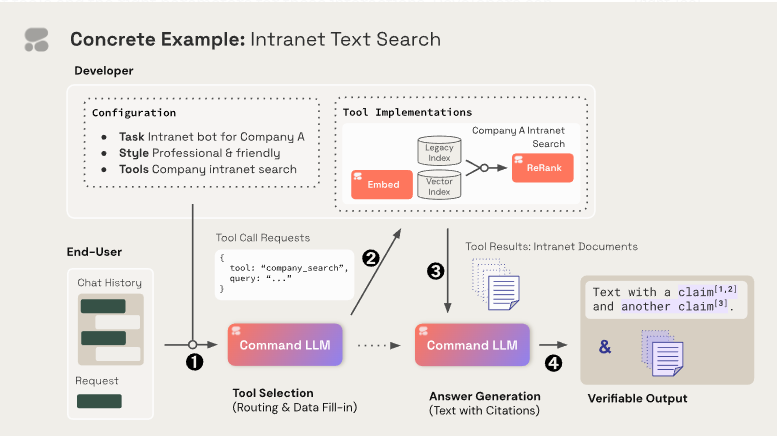

In [13]:
import cohere, json, os
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv('COHERE_API_KEY')
co = cohere.Client(API_KEY)

### Mocked Up Data on Database

In [14]:
# Mock database containing daily sales reports
sales_database = {
    '2023-09-28': {
        'total_sales_amount': 5000,
        'total_units_sold': 100,
    },
    '2023-09-29': {
        'total_sales_amount': 10000,
        'total_units_sold': 250,
    },
    '2023-09-30': {
        'total_sales_amount': 8000,
        'total_units_sold': 200,
    }
}

# Mock product catalog
product_catalog = {
    'Electronics': [
        {'product_id': 'E1001', 'name': 'Smartphone', 'price': 500, 'stock_level': 20},
        {'product_id': 'E1002', 'name': 'Laptop', 'price': 1000, 'stock_level': 15},
        {'product_id': 'E1003', 'name': 'Tablet', 'price': 300, 'stock_level': 25},
    ],
    'Clothing': [
        {'product_id': 'C1001', 'name': 'T-Shirt', 'price': 20, 'stock_level': 100},
        {'product_id': 'C1002', 'name': 'Jeans', 'price': 50, 'stock_level': 80},
        {'product_id': 'C1003', 'name': 'Jacket', 'price': 100, 'stock_level': 40},
    ]
}

### Function on Sales

In [15]:
def query_daily_sales_report(day: str) -> dict:
    """
    Function to retrieve the sales report for the given day
    """
    report = sales_database.get(day, {})
    if report:
        return {
            'date': day,
            'summary': f"Total Sales Amount: {report['total_sales_amount']}, Total Units Sold: {report['total_units_sold']}"
        }
    else:
        return {'date': day, 'summary': 'No sales data available for this day.'}

### Function on Products

In [16]:
def query_product_catalog(category: str) -> dict:
    """
    Function to retrieve products for the given category
    """
    products = product_catalog.get(category, [])
    return {
        'category': category,
        'products': products
    }

### Function Mapping

In [17]:
functions_map = {
    "query_daily_sales_report": query_daily_sales_report,
    "query_product_catalog": query_product_catalog
}

### Tool Description

In [18]:
# tool descriptions that the model has access to
# note: Cohere always adds a "directly_answer" tool under the hood, so that the model can decide to not leverage any tool, if they're not needed.
tools = [
    {
        "name": "query_daily_sales_report",
        "description": "Connects to a database to retrieve overall sales volumes and sales information for a given day.",
        "parameter_definitions": {
            "day": {
                "description": "Retrieves sales data for this day, formatted as YYYY-MM-DD.",
                "type": "str",
                "required": True
            }
        }
    },
    {
        "name": "query_product_catalog",
        "description": "Connects to a a product catalog with information about all the products being sold, including categories, prices, and stock levels.",
        "parameter_definitions": {
            "category": {
                "description": "Retrieves product information data for all products in this category.",
                "type": "str",
                "required": True
            }
        }
    }
]

### Instructions

In [19]:
# preamble containing instructions about the task and the desired style for the output.
preamble = """
## Task & Context
You help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or similar tools to help you, which you use to research your answer. You should focus on serving the user's needs as best you can, which will be wide-ranging.

## Style Guide
Unless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling.
"""

In [20]:
# user request
message = "Can you provide a sales summary for 29th September 2023, \
           and also give me some details about the products in the 'Electronics' \
           category, for example their prices and stock levels?"

### Tools + Cohere Model

In [21]:
response = co.chat(
    message=message,
    tools=tools,
    preamble=preamble,
    model="command-r"
)

# Note that the Cohere Chat API also exposes:
# - stream (for streaming mode)
# - chat_history
# - among other parameters
# See https://docs.cohere.com/reference/chat for details.

print("The model recommends doing the following tool calls:")
print("\n".join(str(tool_call) for tool_call in response.tool_calls))

The model recommends doing the following tool calls:
cohere.ToolCall {
	name: query_daily_sales_report
	parameters: {'day': '2023-09-29'}
	generation_id: None
}
cohere.ToolCall {
	name: query_product_catalog
	parameters: {'category': 'Electronics'}
	generation_id: None
}


### Tool response

In [22]:
tool_results = []
# Iterate over the tool calls generated by the model
for tool_call in response.tool_calls:
    # here is where you would call the tool recommended by the model, using the parameters recommended by the model
    print(f"= running tool {tool_call.name}, with parameters: {tool_call.parameters}")
    output = functions_map[tool_call.name](**tool_call.parameters)
    # store the output in a list
    outputs = [output]
    print(f"== tool results: {outputs}")
    # store your tool results in this format
    tool_results.append({
        "call": tool_call,
        "outputs": outputs
    })

print("Tool results that will be fed back to the model in step 4:")
print(json.dumps(tool_results, indent=4))

= running tool query_daily_sales_report, with parameters: {'day': '2023-09-29'}
== tool results: [{'date': '2023-09-29', 'summary': 'Total Sales Amount: 10000, Total Units Sold: 250'}]
= running tool query_product_catalog, with parameters: {'category': 'Electronics'}
== tool results: [{'category': 'Electronics', 'products': [{'product_id': 'E1001', 'name': 'Smartphone', 'price': 500, 'stock_level': 20}, {'product_id': 'E1002', 'name': 'Laptop', 'price': 1000, 'stock_level': 15}, {'product_id': 'E1003', 'name': 'Tablet', 'price': 300, 'stock_level': 25}]}]
Tool results that will be fed back to the model in step 4:
[
    {
        "call": {
            "name": "query_daily_sales_report",
            "parameters": {
                "day": "2023-09-29"
            },
            "generation_id": null
        },
        "outputs": [
            {
                "date": "2023-09-29",
                "summary": "Total Sales Amount: 10000, Total Units Sold: 250"
            }
        ]
    },

In [23]:
response = co.chat(
    message=message,
    tools=tools,
    tool_results=tool_results,
    preamble=preamble,
    model="command-r",
    temperature=0.3
)

In [24]:
print("Final answer:")
print(response.text)

Final answer:
## Sales Summary - 29th September 2023

Total sales amount: £10,000 
Total units sold: 250

## Electronics Department
There are currently three products in the electronics department:
- Smartphones: £500 each, 20 in stock
- Laptops: £1000 each, 15 in stock
- Tablets: £300 each, 25 in stock


### Citations

In [25]:
print("Citations that support the final answer:")
for cite in response.citations:
  print(cite)

Citations that support the final answer:
{'start': 19, 'end': 38, 'text': '29th September 2023', 'document_ids': ['query_daily_sales_report:0:0']}
{'start': 40, 'end': 67, 'text': 'Total sales amount: £10,000', 'document_ids': ['query_daily_sales_report:0:0']}
{'start': 69, 'end': 90, 'text': 'Total units sold: 250', 'document_ids': ['query_daily_sales_report:0:0']}
{'start': 186, 'end': 197, 'text': 'Smartphones', 'document_ids': ['query_product_catalog:1:0']}
{'start': 199, 'end': 203, 'text': '£500', 'document_ids': ['query_product_catalog:1:0']}
{'start': 210, 'end': 221, 'text': '20 in stock', 'document_ids': ['query_product_catalog:1:0']}
{'start': 224, 'end': 231, 'text': 'Laptops', 'document_ids': ['query_product_catalog:1:0']}
{'start': 233, 'end': 238, 'text': '£1000', 'document_ids': ['query_product_catalog:1:0']}
{'start': 245, 'end': 256, 'text': '15 in stock', 'document_ids': ['query_product_catalog:1:0']}
{'start': 259, 'end': 266, 'text': 'Tablets', 'document_ids': ['qu

### Ordering Citations

In [26]:
def insert_citations_in_order(text, citations):
    """
    A helper function to pretty print citations.
    """
    offset = 0
    document_id_to_number = {}
    citation_number = 0
    modified_citations = []

    # Process citations, assigning numbers based on unique document_ids
    for citation in citations:
        citation_numbers = []
        for document_id in sorted(citation["document_ids"]):
            if document_id not in document_id_to_number:
                citation_number += 1  # Increment for a new document_id
                document_id_to_number[document_id] = citation_number
            citation_numbers.append(document_id_to_number[document_id])

        # Adjust start/end with offset
        start, end = citation['start'] + offset, citation['end'] + offset
        placeholder = ''.join([f'[{number}]' for number in citation_numbers])
        # Bold the cited text and append the placeholder
        modification = f'**{text[start:end]}**{placeholder}'
        # Replace the cited text with its bolded version + placeholder
        text = text[:start] + modification + text[end:]
        # Update the offset for subsequent replacements
        offset += len(modification) - (end - start)

    # Prepare citations for listing at the bottom, ensuring unique document_ids are listed once
    unique_citations = {number: doc_id for doc_id, number in document_id_to_number.items()}
    citation_list = '\n'.join([f'[{doc_id}] source: {tool_results[doc_id - 1]["outputs"]} \n    based on tool call: {dict(tool_results[doc_id - 1]["call"])}' for doc_id, number in sorted(unique_citations.items(), key=lambda item: item[1])])
    text_with_citations = f'{text}\n\n{citation_list}'

    return text_with_citations


print(insert_citations_in_order(response.text, response.citations))

## Sales Summary - **29th September 2023**[1]

**Total sales amount: £10,000**[1] 
**Total units sold: 250**[1]

## Electronics Department
There are currently three products in the electronics department:
- **Smartphones**[2]: **£500**[2] each, **20 in stock**[2]
- **Laptops**[2]: **£1000**[2] each, **15 in stock**[2]
- **Tablets**[2]: **£300**[2] each, **25 in stock**[2]

[1] source: [{'date': '2023-09-29', 'summary': 'Total Sales Amount: 10000, Total Units Sold: 250'}] 
    based on tool call: {'name': 'query_daily_sales_report', 'parameters': {'day': '2023-09-29'}, 'generation_id': None}
[2] source: [{'category': 'Electronics', 'products': [{'product_id': 'E1001', 'name': 'Smartphone', 'price': 500, 'stock_level': 20}, {'product_id': 'E1002', 'name': 'Laptop', 'price': 1000, 'stock_level': 15}, {'product_id': 'E1003', 'name': 'Tablet', 'price': 300, 'stock_level': 25}]}] 
    based on tool call: {'name': 'query_product_catalog', 'parameters': {'category': 'Electronics'}, 'generation